In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [38]:
country_data = pd.read_csv('./data/country-data.csv')
data_dictionary = pd.read_csv('./data/data-dictionary.csv')

In [39]:
num_countries = country_data.shape[0]
print(f"O número de países no dataset é: {num_countries}")
num_unique_countries = country_data['country'].nunique()
print(f"O número de países únicos no dataset é: {num_unique_countries}")

O número de países no dataset é: 167
O número de países únicos no dataset é: 167


In [40]:
country_data.set_index('country', inplace=True)
country_data.describe().T

,count,mean,std,min,25%,50%,75%,max
child_mort,167.0,38.270060,40.328931,2.6000,8.250,19.30,62.10,208.00
exports,167.0,41.108976,27.412010,0.1090,23.800,35.00,51.35,200.00
health,167.0,6.815689,2.746837,1.8100,4.920,6.32,8.60,17.90
imports,167.0,46.890215,24.209589,0.0659,30.200,43.30,58.75,174.00
income,167.0,17144.688623,19278.067698,609.0000,3355.000,9960.00,22800.00,125000.00
inflation,167.0,7.781832,10.570704,-4.2100,1.810,5.39,10.75,104.00
life_expec,167.0,70.555689,8.893172,32.1000,65.300,73.10,76.80,82.80
total_fer,167.0,2.947964,1.513848,1.1500,1.795,2.41,3.88,7.49
gdpp,167.0,12964.155689,18328.704809,231.0000,1330.000,4660.00,14050.00,105000.00


Já de início pode se perceber que os valores de income e gdpp possuem valores máximos MUITO acima dos outros valores

/var/folders/0d/h4ww2hdn1b912t6nchjlj9940000gn/T/ipykernel_3510/1864495679.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


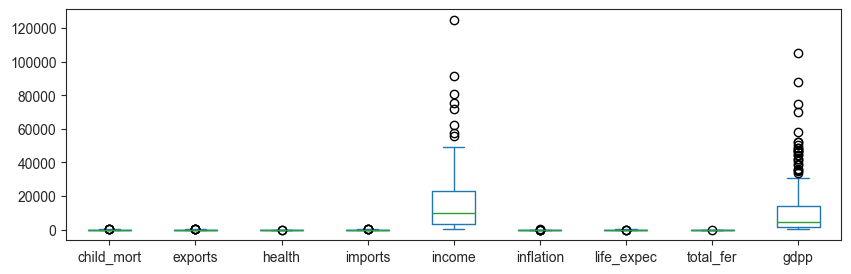

In [41]:
fig, ax = plt.subplots()
country_data.plot(kind='box', ax=ax, figsize=(10,3))
fig.show()

A partir do gráfico boxplot acima é muito mais fácil notar a grande diferença de escala das variáveis income e gdpp assim como alguns outliers. Sendo assim, necessário fazer uma normalização destes dados

In [42]:
# Centralizando todos os dados e colocando todo mundo com desvio padrão igualitário

scaler = StandardScaler()
country_data_scaled = scaler.fit_transform(country_data)
country_data_scaled = pd.DataFrame(country_data_scaled, columns=country_data.columns, index=country_data.index)

/var/folders/0d/h4ww2hdn1b912t6nchjlj9940000gn/T/ipykernel_3510/1597624000.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


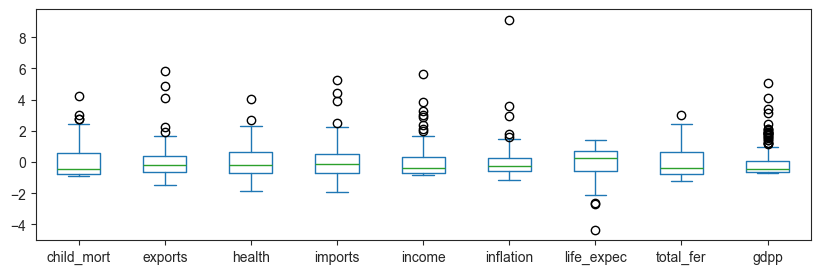

In [43]:
fig, ax = plt.subplots()
country_data_scaled.plot(kind='box', ax=ax, figsize=(10,3))
fig.show()

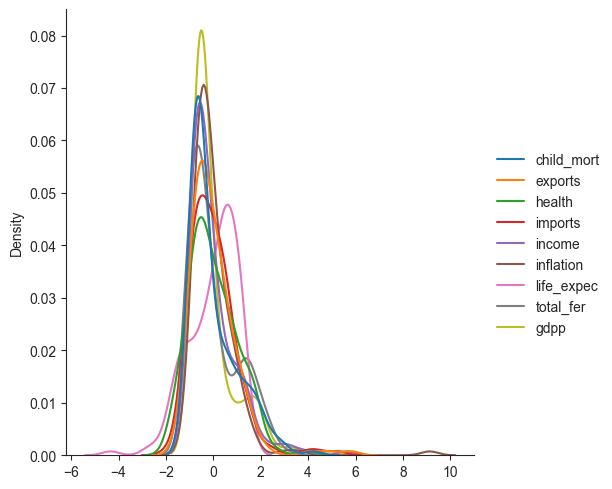

In [44]:
sns.displot(country_data_scaled, kind='kde')

<Axes: >

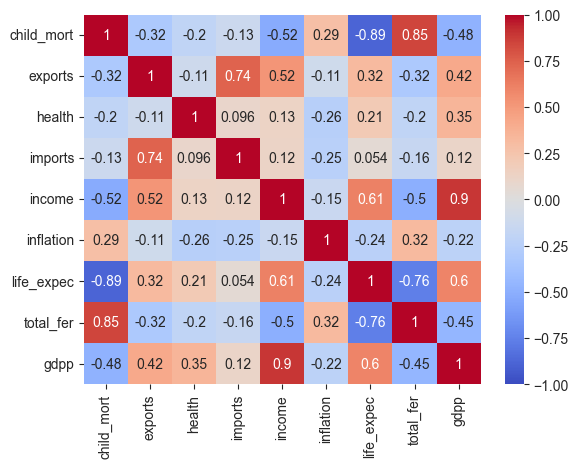

In [45]:
# Também é bom analizar o
sns.heatmap(country_data_scaled.corr(), cmap='coolwarm', annot=True, vmax=1, vmin=-1)

Algumas observações a respeito da matriz de correlação:

child_mor e total_fer são altamente correlacionadas, o que faz sentido, pois quanto maior a taxa de mortalidade infantil, maior a taxa de fertilidade.<br>
exports e imports são altamente correlacionadas.<br>
income e gdpp são altamente correlacionadas.<br>

In [46]:
min_clusters = 2
max_clusters = 10
n_init = 100

errors = []
for n_clusters in range(min_clusters, max_clusters):
  model = KMeans(
      n_clusters = n_clusters,
      init = "random",
      n_init = n_init,
      max_iter=1000,
  )

  model.fit(country_data_scaled)
  errors.append((n_clusters, model.inertia_))

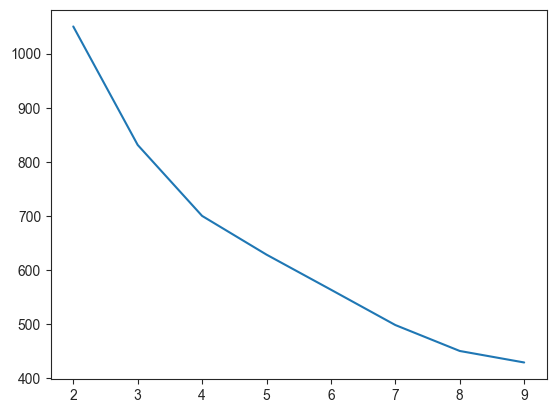

In [47]:
clusters, inertia = zip(*errors)
plt.plot(clusters, inertia)

A partir da análise de cotovelo é possível notar que perto de 3 clusters, o erro já diminui bastante. Sendo assim este seria um valor interessante para o número de grupos para resolver o problema

In [48]:
best_n_clusters = 3
n_init = 100
# n_init=100
model = KMeans(
    n_clusters = best_n_clusters,
    init="random",
    n_init=n_init,
    max_iter=1000,
)

model.fit(country_data_scaled)

results = country_data_scaled.copy()
results['cluster'] = model.predict(country_data_scaled)

In [50]:
results['cluster'].value_counts()

cluster
2    84
0    47
1    36
Name: count, dtype: int64

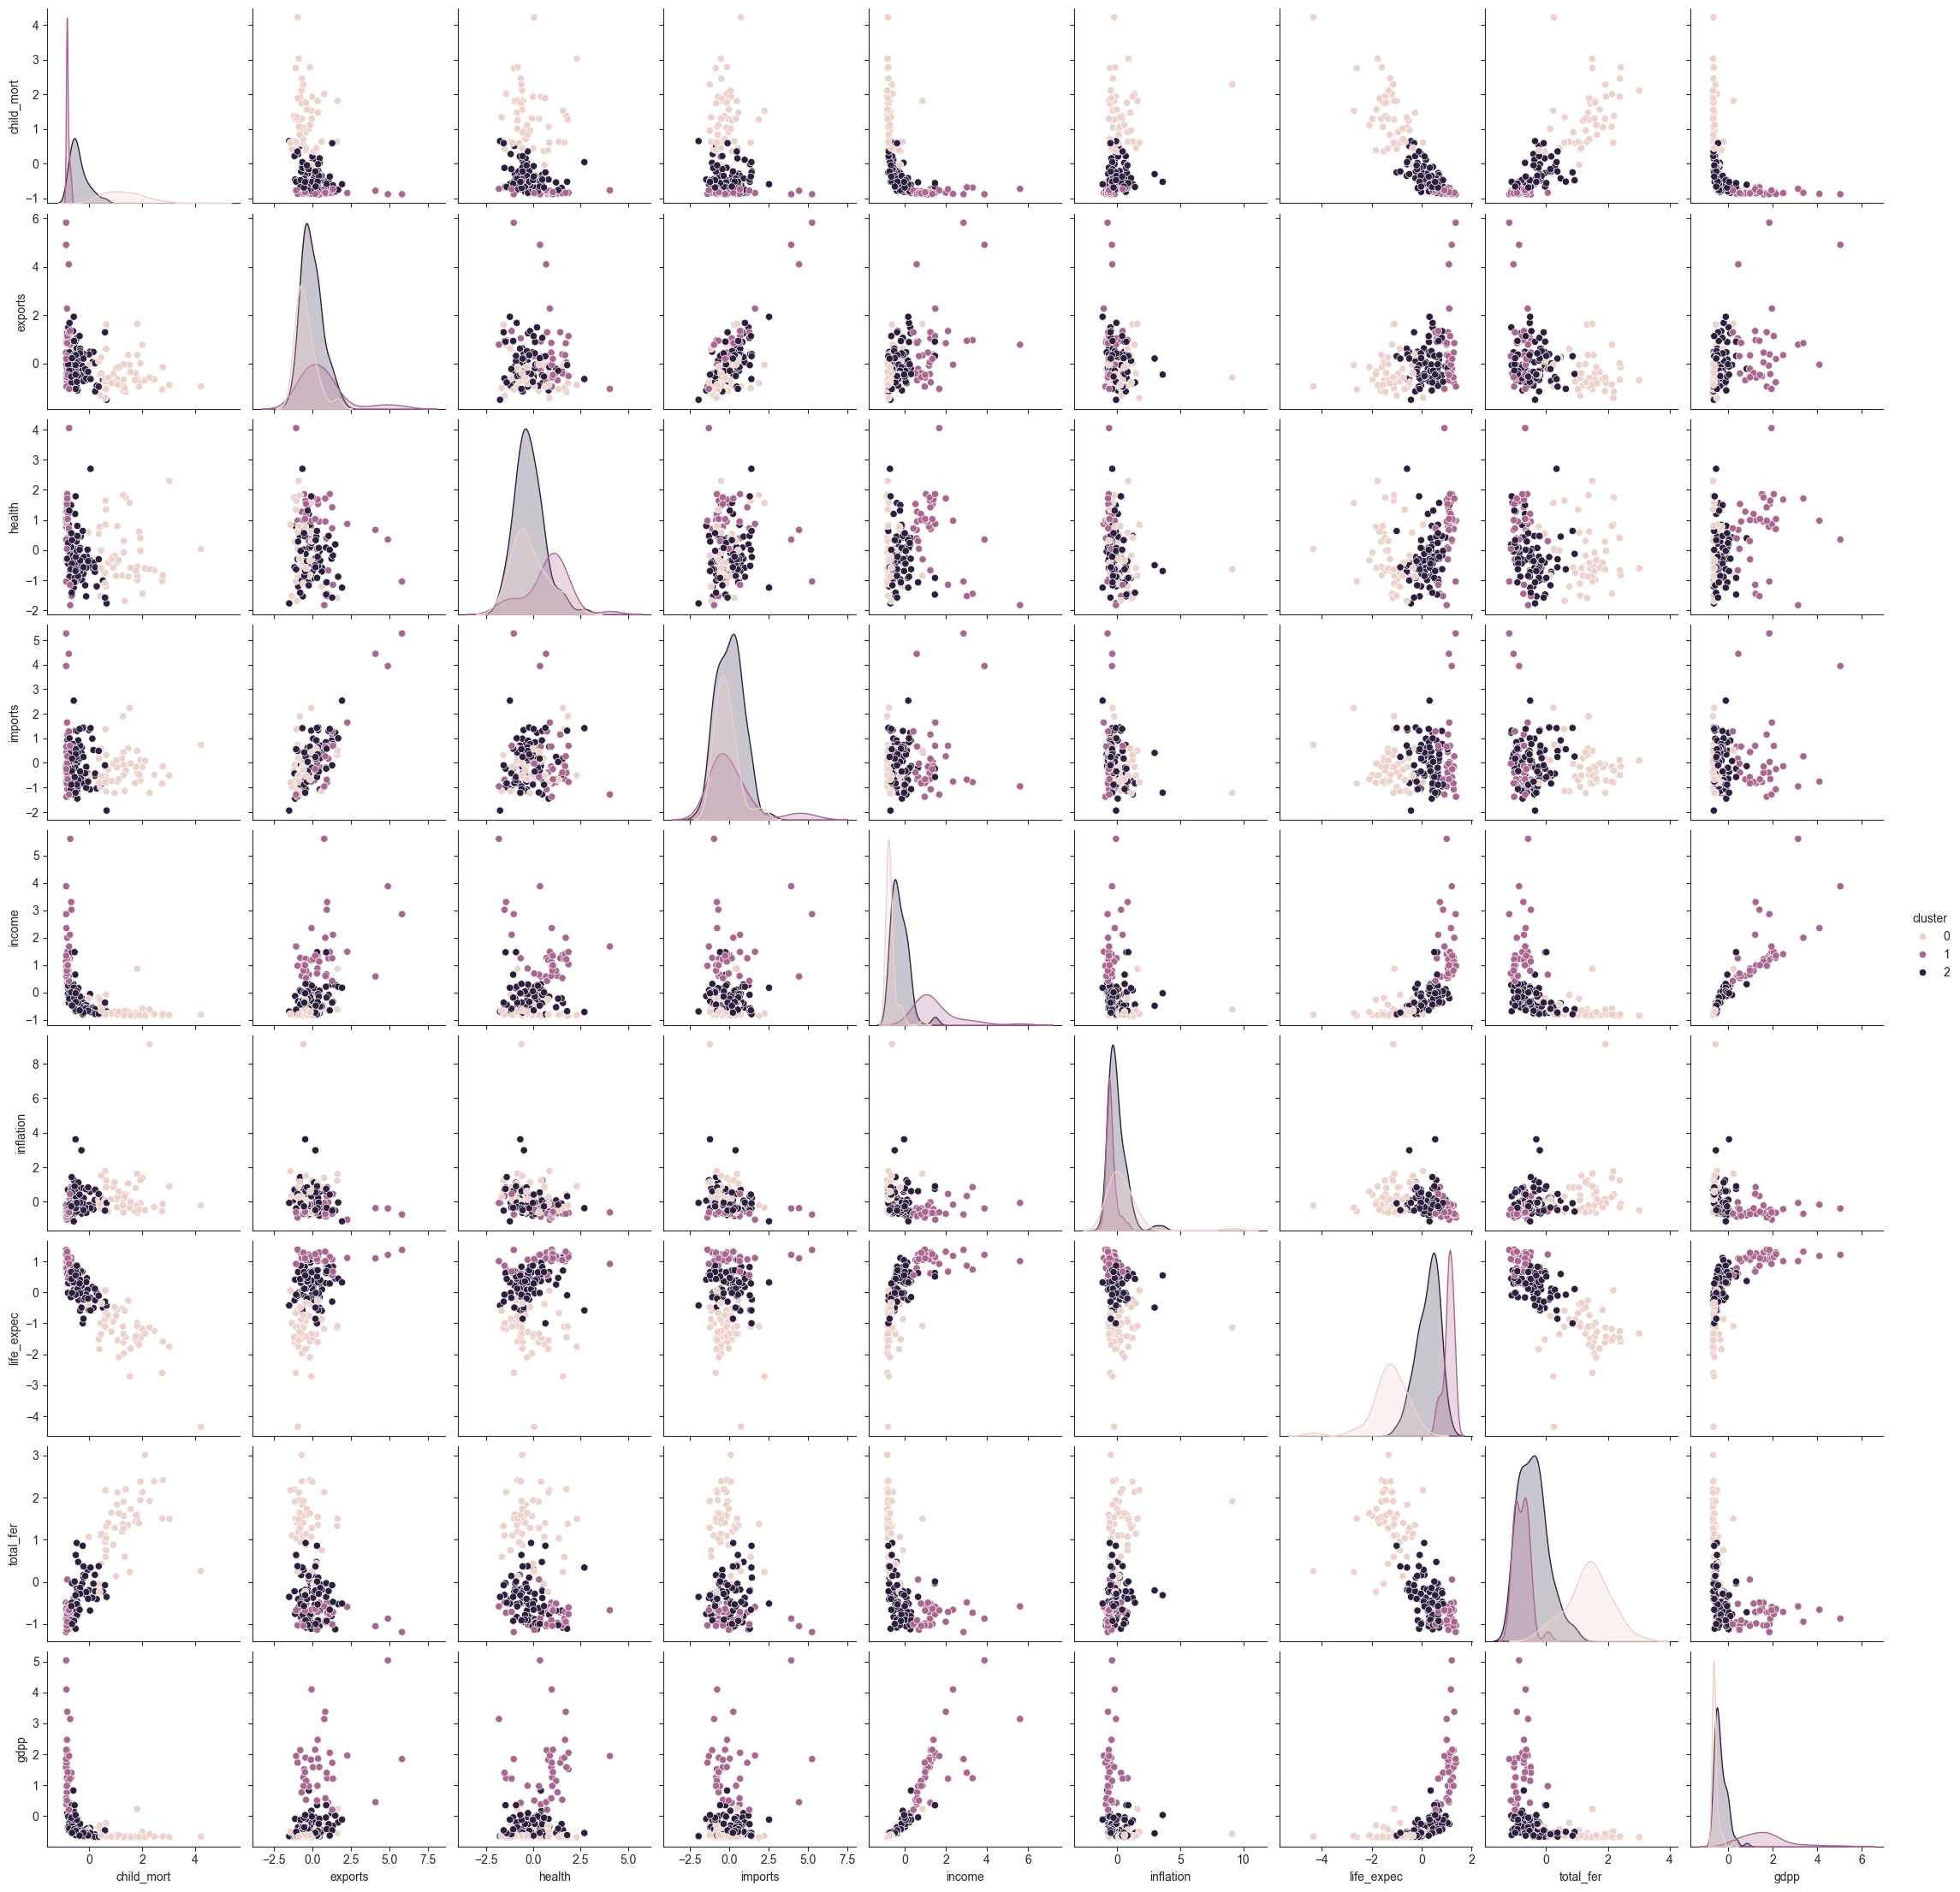

In [51]:
sns.pairplot(results, hue='cluster')

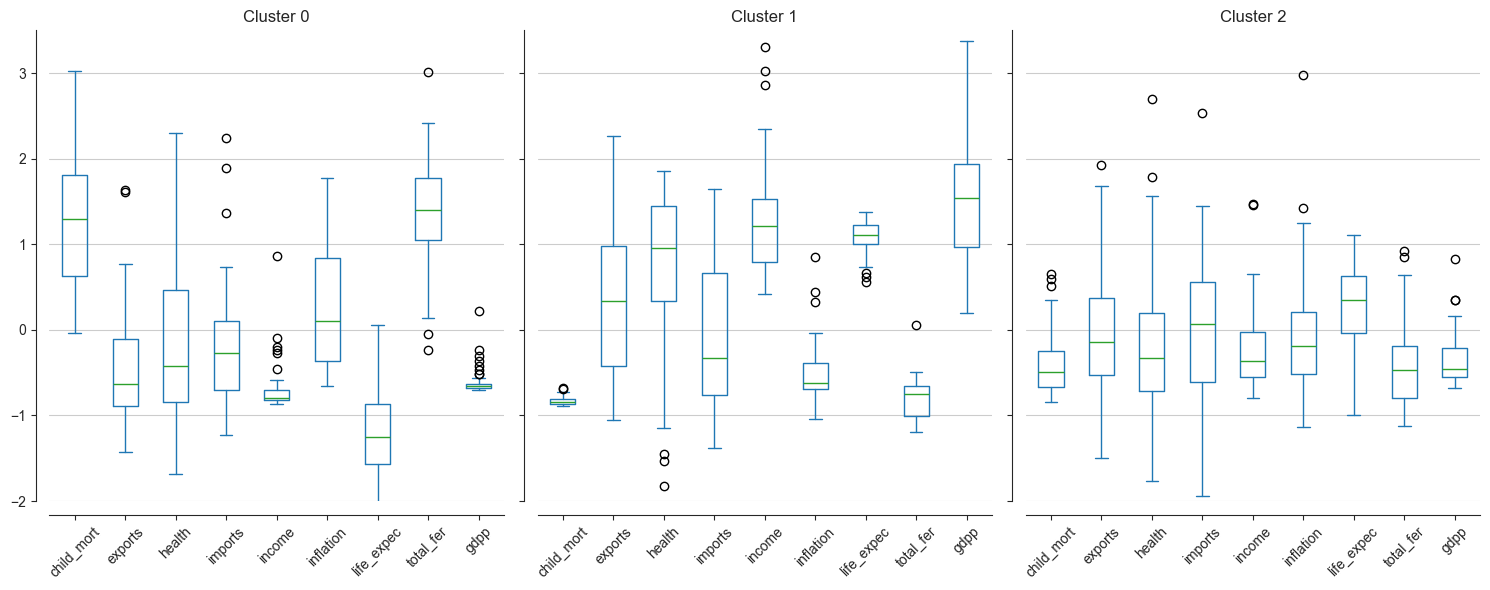

In [57]:
fig, axes = plt.subplots(1, 3, figsize=(15, 6), sharey=True)

sns.set_style('ticks')
for idx in range(0, 3):
    box_plot = country_data_scaled[results.cluster==idx].plot(kind='box', ax=axes[idx])
    axes[idx].set_title(f'Cluster {idx}')
    axes[idx].yaxis.grid(True)
    axes[idx].set_ylim([-2, 3.5])
    sns.despine(offset=10)

# Rotacionar as legendas do eixo x em 45 graus em todos os subplots
for ax in axes:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

fig.tight_layout()


Calculando a distância euclidiana entre os países